# Preprocessing and Modeling
Having cleaned and explored the wikikhow test data I will begin preprocessing the data for modeling, building the model architecture, training the model, and finally assessing model performance.

In [196]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,LSTM, Embedding, Dense, Attention, Concatenate, TimeDistributed, Masking
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [3]:
Data = pd.read_csv('Data/Wikihow_clean_50000', nrows = 10000)
Data = Data.dropna(axis = 0)
Data.head()

,Unnamed: 0,headline,title,text,clean_text,cleaned_headline
0,0,"\nKeep related supplies in the same area.,\nMa...",How to Be an Organized Artist1,"If you're a photographer, keep all the necess...",photographer keep necessary lens cords batteri...,_START_ keep related supplies in the same area...
1,1,\nCreate a sketch in the NeoPopRealist manner ...,How to Create a Neopoprealist Art Work,See the image for how this drawing develops s...,see image drawing develops step step however i...,_START_ create sketch in the neopoprealist man...
2,2,"\nGet a bachelor’s degree.,\nEnroll in a studi...",How to Be a Visual Effects Artist1,It is possible to become a VFX artist without...,possible become vfx artist without college deg...,_START_ get bachelor degree enroll in studio b...
3,3,\nStart with some experience or interest in ar...,How to Become an Art Investor,The best art investors do their research on t...,best art investors research pieces art buy som...,_START_ start with some experience or interest...
4,4,"\nKeep your reference materials, sketches, art...",How to Be an Organized Artist2,"As you start planning for a project or work, ...",start planning project work likely gathering s...,_START_ keep your reference materials sketches...


In [4]:
Data.iloc[1000,5]

'_START_ let your dwarf hamster get used to his new environment spend quiet time with your dwarf hamster talk to your dwarf hamster pick good time to tame your dwarf hamster wash your hands lower your hands into your dwarf hamster cage lift your dwarf hamster up and let him explore you hold your dwarf hamster each day learn the difference between biting and nibbling react properly if your dwarf hamster bites you do not stick your hand in your dwarf hamster cage  _END_'

## Preprocessing
Preprocessing the data involves splitting the data into training and test sets. I'll take eighty percent of the data for training and the rest for validation. After the data is split I initialize values for maximum text length and maximum summary length. I then tokenize the training and validation sets transforming each entry from a readable text to equally lengthed sequences of numbers that can be processed by a word embedding layer. This is done to both the texts and summaries with their respective lengths applied to both the training and test sets

In [131]:
X_train, X_test, y_train, y_test = train_test_split(Data['clean_text'], Data['cleaned_headline'], test_size = .2, random_state = 4, shuffle = True) 

In [6]:
print(len(X_train), len(X_test))

7889 1973


In [7]:
# max_len values set the maximum length for both the text and summary these values cames from previous Explorartory Data Analysis
max_len_text = 300
max_len_summary = 70

In [132]:
# The tokenizer creates a 'token' for each word which is a number that corresponds with that word
X_tokenizer = Tokenizer(filters = '!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n', lower = False)
X_tokenizer.fit_on_texts(list(X_train))

# Transforming the sequence of words into a corresponding sequence of their respective tokens
X_train = X_tokenizer.texts_to_sequences(X_train)
X_test = X_tokenizer.texts_to_sequences(X_test)

# Padding ensures that the sequences are all of the same size by adding empty tokens up to the max length 
X_train = pad_sequences(X_train,  maxlen=max_len_text, padding='post') 
X_test = pad_sequences(X_test, maxlen=max_len_text, padding='post')

# X_tokenizer.word_index['UNK'] = 0
# X_tokenizer.index_word[0] = 'UNK'

x_voc_size = len(X_tokenizer.word_index) +1

In [133]:
y_tokenizer = Tokenizer(filters = '!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n', lower = False)
y_tokenizer.fit_on_texts(list(y_train))


y_train = y_tokenizer.texts_to_sequences(y_train)
y_test = y_tokenizer.texts_to_sequences(y_test)

y_train = pad_sequences(y_train,  maxlen=max_len_summary, padding='post') 
y_test = pad_sequences(y_test, maxlen=max_len_summary, padding='post')

# y_tokenizer.word_index['UNK'] = 0
# y_tokenizer.index_word[0] = 'UNK'

y_voc_size = len(y_tokenizer.word_index) +1

In [123]:
print(x_voc_size, y_voc_size)

37174 15318


## Embedding Layer

Rather than having my model develop it's own word embeddings, This model will use pre trained embeddings from the Word2Vec model. This will save time during training at the sacrifice of certain words not present in the Word2Vec vocabulary not having their own embeddings.  

In [11]:
import smart_open
smart_open.open = smart_open.smart_open
from gensim.models import Word2Vec
import gensim.downloader as api
v2w_model = api.load('word2vec-google-news-300')

C:\Users\Allen\anaconda3\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [14]:
embedding_matrix_X = np.zeros((x_voc_size, 300))
for word, index in X_tokenizer.word_index.items():
    if word not in v2w_model:
        continue
    else: embedding_matrix_X[index] = v2w_model[word]

In [15]:
embedding_matrix_y = np.zeros((y_voc_size, 300))
for word, index in y_tokenizer.word_index.items():
    if word not in v2w_model:
        continue
    else: embedding_matrix_y[index] = v2w_model[word]

### Embedding words not in pretrained embedding

In [88]:
Xemb_trained = []
Xemb_untrained = []
for word, index in X_tokenizer.word_index.items():
    if word not in v2w_model:
        Xemb_untrained.append(word)
    else: Xemb_trained.append(word)

In [92]:
# Percentage of unembedded words in vocabulary
print(len(Xemb_untrained) / (len(Xemb_untrained) + len(Xemb_trained)))

0.09227375443882492


## Creating lagged Y's
In order for the model to be properly trained. The Y variable needs to be lagged by one token so that the data is trained to predict the next word.

In [116]:
y_train_l = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:]
y_test_l = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]

end_array_train = np.full((y_train.shape[0],1,1), 0)
end_array_test = np.full((y_test.shape[0],1,1), 0)

y_train_l = np.append(y_train_l, end_array_train, axis = 1)
y_test_l = np.append(y_test_l, end_array_test, axis = 1)

# print(y_train[0,:], y_train_l[0,:])

In [60]:
y_train_l.shape

(7889, 80, 1)

## Building the Model
With the data ready to be modeled I use functional Keras to begin constructing an architecture that can model the data. I set the latent dimension which determines the size of the word embeddings and begin with an input that fits the set shape of each text entry. 

In [135]:
from keras import backend as K 

K.clear_session() 

# The latent dimension is the number of dimensions that each word embedding will correspond with
latent_dim = 300


#Embedding layer
Encoder_inputs = Input(shape=(max_len_text,))

mask = Masking(mask_value = 0)

encoder_mask = mask(Encoder_inputs)



Encoder_embedding = Embedding(x_voc_size, latent_dim,weights = [embedding_matrix_X],trainable=False)(encoder_mask) 


lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True, name = 'lstm1') 

encoder_output1, h_state, c_state = lstm1(Encoder_embedding) 

# Decoder

decoder_inputs = Input(shape=(None,))

decoder_mask = mask(decoder_inputs)

decoder_embedding = Embedding(y_voc_size, latent_dim,weights = [embedding_matrix_y],trainable=False)

dec_emb = decoder_embedding(decoder_mask) 


#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name = 'decoder_lstm') 
decoder_lstm_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[h_state, c_state]) 


#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_lstm_outputs) 

# Define the model
model_1 = Model([Encoder_inputs, decoder_inputs], decoder_outputs)

In [137]:
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
masking (Masking)               multiple             0           input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 300)     11151900    masking[0][0]                

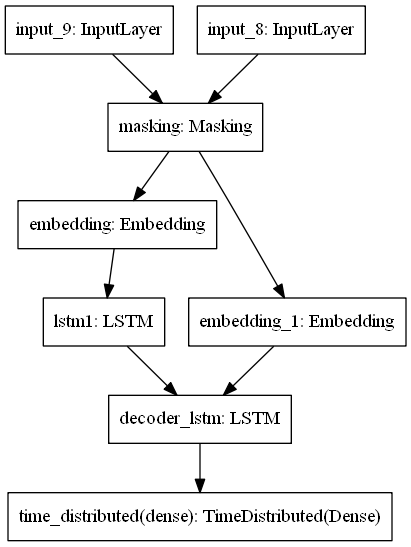

In [210]:
plot_model(model_1)

In [166]:
es = EarlyStopping(monitor='val_loss', mode='min', patience = 15, verbose=1)
cp_callback1 = ModelCheckpoint(filepath = 'model_train_1/cp.ckpt', save_best_only = True, verbose  = 1)

In [138]:
model_1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [183]:
history = model_1.fit([X_train,y_train], y_train_l,
                    epochs = 5, batch_size = 125, 
                    validation_data = ([X_test,y_test], y_test_l), callbacks = [es, cp_callback1])

Epoch 1/5
64/64 [==============================] - 443s 7s/step - loss: 2.2116 - val_loss: 2.8893

Epoch 00001: saving model to model_train_1\cp.ckpt
Epoch 2/5
64/64 [==============================] - 448s 7s/step - loss: 2.1859 - val_loss: 2.8863

Epoch 00002: saving model to model_train_1\cp.ckpt
Epoch 3/5
64/64 [==============================] - 454s 7s/step - loss: 2.1619 - val_loss: 2.8842

Epoch 00003: saving model to model_train_1\cp.ckpt
Epoch 4/5
64/64 [==============================] - 453s 7s/step - loss: 2.1375 - val_loss: 2.8845

Epoch 00004: saving model to model_train_1\cp.ckpt
Epoch 5/5
64/64 [==============================] - 453s 7s/step - loss: 2.1129 - val_loss: 2.8982

Epoch 00005: saving model to model_train_1\cp.ckpt


In [186]:
model_1.save('first_model.h5')

In [184]:
encoder_model1 = Model(inputs = Encoder_inputs, outputs = [encoder_output1, h_state, c_state])

decoder_h_state_input = Input(shape=(latent_dim,))
decoder_c_state_input = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

dec_emb2 = decoder_embedding(decoder_inputs)

decoder_outputs2 , h_state2, c_state2  = decoder_lstm(dec_emb2,initial_state=[decoder_h_state_input, decoder_c_state_input])

decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model1 = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_h_state_input, decoder_c_state_input],
                     [decoder_outputs2] + [h_state2, c_state2])

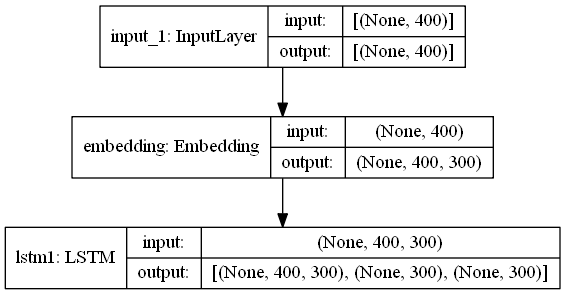

In [66]:
plot_model(encoder_model1, show_shapes = True)

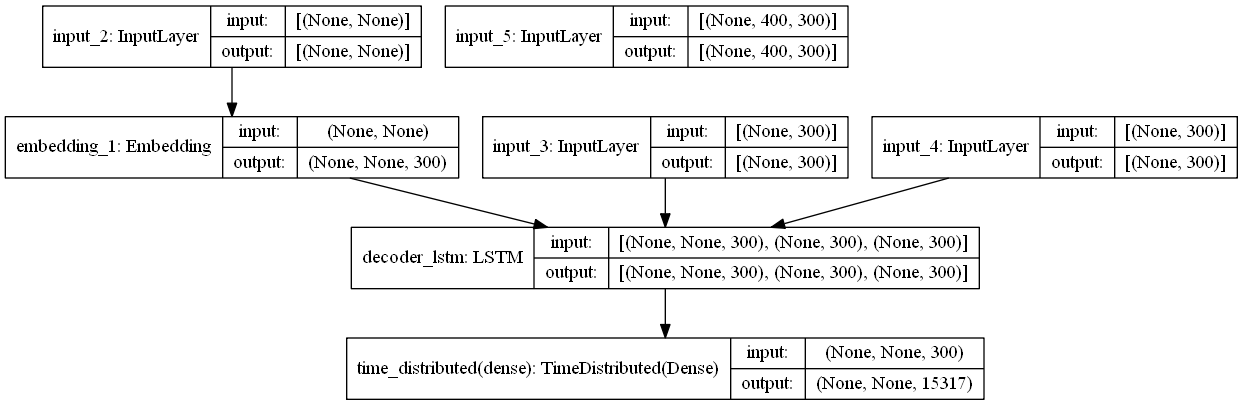

In [67]:
plot_model(decoder_model1, show_shapes = True)

In [185]:
decode_sequence(X_train[2], encoder_model1, decoder_model1, latent_dim = 300)

' with your own to the right to the right to the right to the right to the right to the right to the right to the right to the right to the right to the right to the right to the right to the right to the right to the right to the right to the right to the right to the right to the right to the right to the right to the right to the right to'

# Adding Layers and Attention

In [188]:
from keras import backend as K 

K.clear_session() 

# The latent dimension is the number of dimensions that each word embedding will correspond with
latent_dim = 300 


#Embedding layer
Encoder_inputs = Input(shape=(max_len_text,))

mask = Masking(mask_value = 0)

encoder_mask = mask(Encoder_inputs)

Encoder_embedding = Embedding(x_voc_size, latent_dim,weights = [embedding_matrix_X],trainable=False)(encoder_mask) 


lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True, name = 'lstm1') 

encoder_output1, h1, c1 = lstm1(Encoder_embedding) 


lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True, name = 'lstm2') 

encoder_output2, h2, c2 = lstm2(encoder_output1) 


lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, name = 'lstm3') 

encoder_outputs, h_state, c_state = lstm3(encoder_output2) 


# Decoder

decoder_inputs = Input(shape=(None,))

decoder_mask = mask(decoder_inputs)

decoder_embedding = Embedding(y_voc_size, latent_dim,weights = [embedding_matrix_y],trainable=False)

dec_emb = decoder_embedding(decoder_mask) 


#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name = 'decoder_lstm') 
decoder_lstm_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[h_state, c_state]) 


#Attention Layer
attention_output = Attention()([decoder_lstm_outputs, encoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis= -1, name='concat_layer')([decoder_lstm_outputs, attention_output])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model2 = Model([Encoder_inputs, decoder_inputs], decoder_outputs) 

In [189]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 400)]        0                                            
__________________________________________________________________________________________________
masking (Masking)               multiple             0           input_20[0][0]                   
                                                                 input_21[0][0]                   
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 300)     11151900    masking[0][0]                

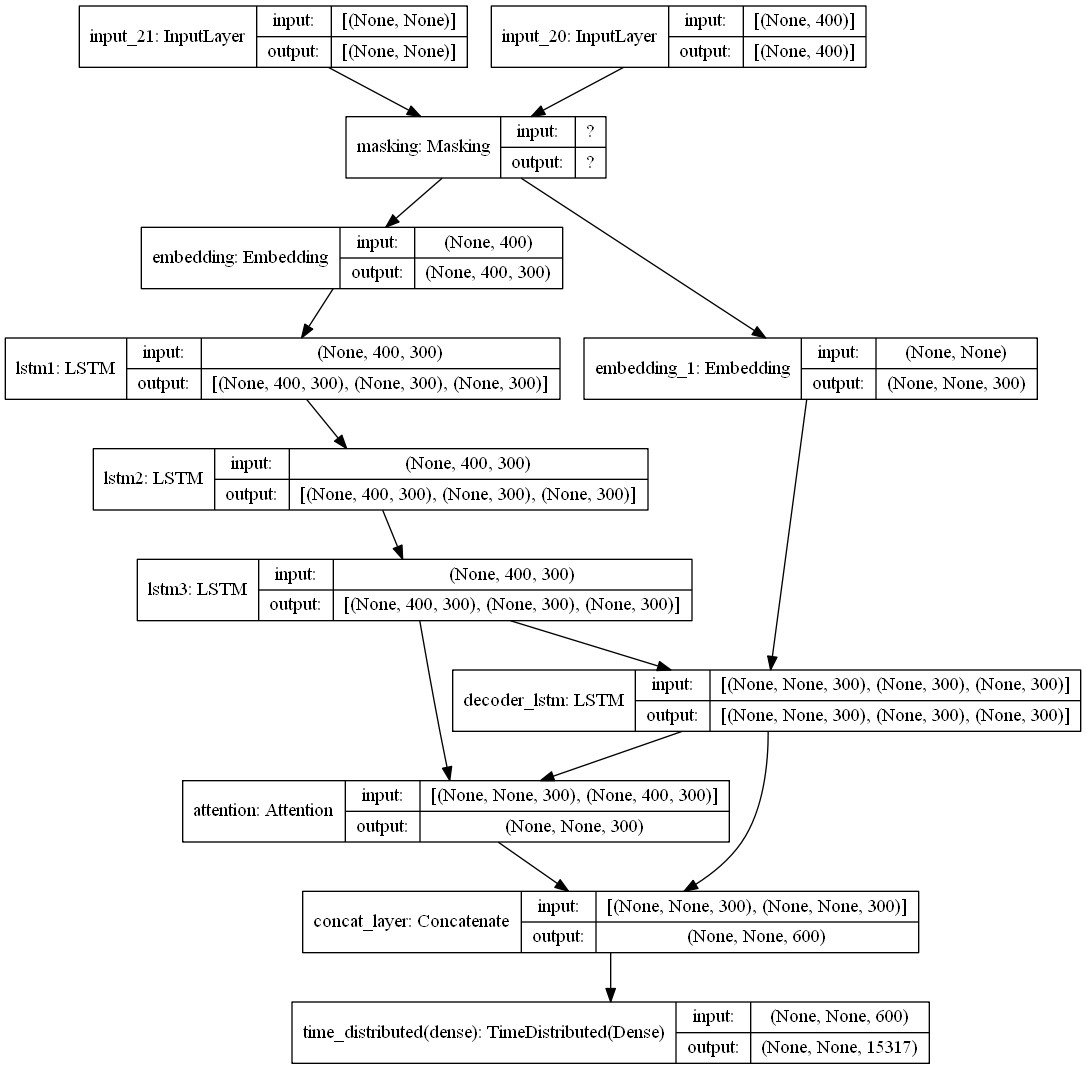

In [191]:
plot_model(model2, show_shapes = True,expand_nested = True )

In [192]:
model2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [193]:
es = EarlyStopping(monitor='val_loss', mode='min', patience = 15, verbose=1)
cp_callback = ModelCheckpoint(filepath = 'model_train_2/cp.ckpt', save_best_only= True, verbose  = 1)

In [ ]:
# Load_model(model, 'model_train_1', 79)

In [195]:
history = model2.fit([X_train,y_train], y_train_l,
                    epochs = 75, batch_size = 125, 
                    validation_data = ([X_test,y_test], y_test_l), callbacks = [es, cp_callback1])

Epoch 1/75
64/64 [==============================] - 1047s 16s/step - loss: 4.3624 - val_loss: 3.8964

Epoch 00001: saving model to model_train_1\cp.ckpt
Epoch 2/75
64/64 [==============================] - 1119s 17s/step - loss: 3.7764 - val_loss: 3.6394

Epoch 00002: saving model to model_train_1\cp.ckpt
Epoch 3/75
64/64 [==============================] - 1119s 17s/step - loss: 3.5550 - val_loss: 3.4651

Epoch 00003: saving model to model_train_1\cp.ckpt
Epoch 4/75
64/64 [==============================] - 1126s 18s/step - loss: 3.3901 - val_loss: 3.3496

Epoch 00004: saving model to model_train_1\cp.ckpt
Epoch 5/75
64/64 [==============================] - 1130s 18s/step - loss: 3.2742 - val_loss: 3.2781

Epoch 00005: saving model to model_train_1\cp.ckpt
Epoch 6/75
64/64 [==============================] - 1124s 18s/step - loss: 3.2076 - val_loss: 3.2161

Epoch 00006: saving model to model_train_1\cp.ckpt
Epoch 7/75
64/64 [==============================] - 1117s 17s/step - loss: 3.1147 

KeyboardInterrupt: 

In [198]:
check_point_path ='model_train_1/cp.ckpt'
checkpoint_dir = os.path.dirname(check_point_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)

model2.load_weights(latest)

In [102]:
model2.save('Models/lstm_attention_model2', save_format = 'h5')

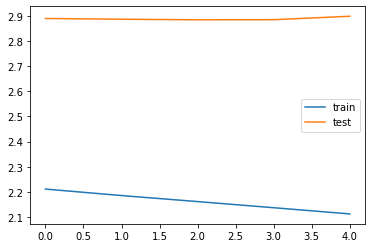

In [201]:
plt.plot(history.history['loss'], label ='train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [71]:
reverse_target_word = y_tokenizer.index_word
reverse_input_word = X_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [205]:
encoder_model2 = Model(inputs = Encoder_inputs, outputs = [encoder_outputs, h_state, c_state])

In [206]:
encoder_model2.outputs

[<KerasTensor: shape=(None, 400, 300) dtype=float32 (created by layer 'lstm3')>,
 <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'lstm3')>,
 <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'lstm3')>]

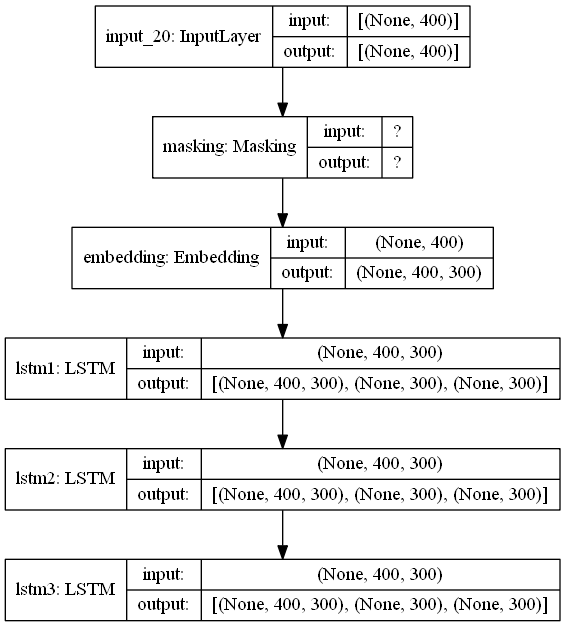

In [207]:
plot_model(encoder_model2, show_shapes = True, to_file = 'encoder_model2.png')

In [212]:
decoder_h_state_input = Input(shape=(latent_dim,))
decoder_c_state_input = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

decoder_mask2 = mask(decoder_inputs)

dec_emb2 = decoder_embedding(decoder_mask2)

decoder_outputs2 , h_state2, c_state2  = decoder_lstm(dec_emb2,initial_state=[decoder_h_state_input, decoder_c_state_input])

attention_output_inf = Attention()([decoder_outputs2, decoder_hidden_state_input]) 

decoder_concat_inf = Concatenate(axis= -1, name='concat')([decoder_outputs2, attention_output_inf])

decoder_outputs2 = decoder_dense(decoder_concat_inf)

decoder_model2 = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_h_state_input, decoder_c_state_input],
                     [decoder_outputs2] + [h_state2, c_state2])

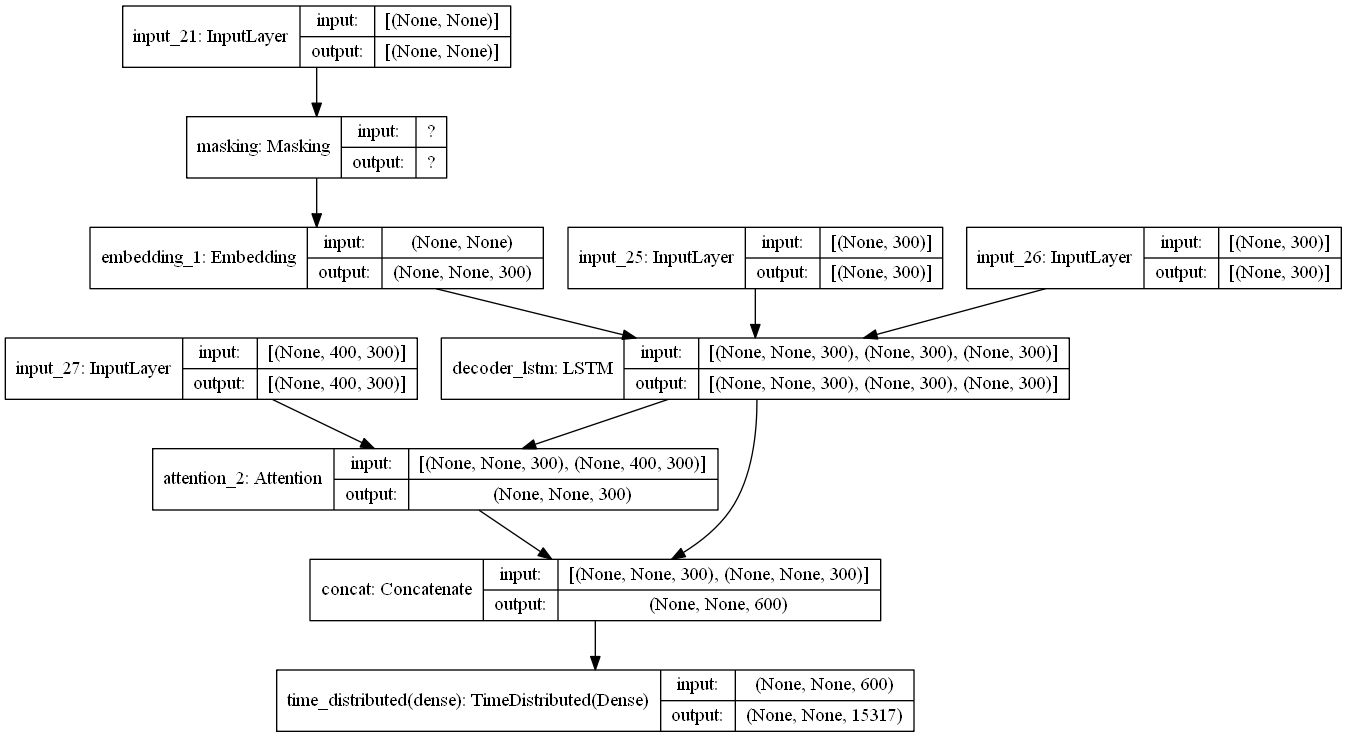

In [213]:
plot_model(decoder_model2, show_shapes = True, to_file = 'decoder_model.png')

# Testing shapes Start

Data Cardinality Order
1. target_seq
2. encode_output
3. encode_h_state
4. encode_c_state

Input Order
'[Input2, Input1, Input2, Input3]'

In [144]:
Fake1 = np.array([np.zeros(154)])
Fake2 = np.array([np.zeros(254)])
Fake3 = np.array([np.zeros(354)])
Fake4 = np.array([np.zeros(454)])

In [117]:
fill1 = np.zeros((1,1))
fill2 = np.array([np.zeros((400,500))])
fill3 = np.array([np.zeros(500)])
# fill4

In [336]:
working_shapes = [fill1.shape, fill2.shape, fill3.shape, fill3.shape]
working_shapes

my_object_shapes = [target_seq.shape, encode_output_r.shape, encode_h_state_r.shape, encode_c_state_r.shape]
my_object_shapes

[(1, 1), (1, 400, 500), (1, 500), (1, 500)]

In [279]:
print(fill1.shape, fill2.shape, fill3.shape, fill3.shape)

(1, 1) (1, 400, 500) (1, 500) (1, 500)


In [405]:
encode_output.shape, np.array([encode_h_state[0]]).shape, np.array([encode_c_state[0]]).shape

((400, 1, 500), (1, 500), (1, 500))

# Testing Shapes End

# Assessing Performance

In [233]:
from nltk.translate.bleu_score import sentence_bleu

In [249]:
def read_input(input):
    sentence = ''
    for index in input:
        if index == 0:
            continue
        else:
            sentence = sentence + ' ' + reverse_input_word[index]
    return(sentence)



def read_target(target):
    sentence = ''
    for index in target:
        if index == 0:
            continue
        else:
            sentence = sentence + ' ' + reverse_target_word[index]
    return(sentence)



def decode_sequence(input_seq, encoder, decoder,latent_dim):
      
    
    encode_output, encode_h_state, encode_c_state = encoder.predict(input_seq)

    encode_h_state_r = np.array([encode_h_state[-1]])
    encode_c_state_r = np.array([encode_c_state[-1]])
    encode_output_r =  encode_output.reshape(1,400,latent_dim)
    
    
    target_seq = np.zeros((1,1))
    
    target_seq[0,0] = target_word_index['_START_']
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder.predict([target_seq] + [encode_output_r, encode_h_state_r, encode_c_state_r])
        
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word[sampled_token_index]
        
        if(sampled_token!='_END_'):
            decoded_sentence += ' ' + sampled_token
            
        if (sampled_token == '_END_' or len(decoded_sentence.split()) >= (max_len_summary - 1)):
            stop_condition = True
                
        target_seq = np.zeros((1,1))
        target_seq[0,0] = sampled_token_index
        
        encode_h_state, encode_c_state = h, c
        
    return decoded_sentence


    

In [254]:
def observe_case(Index, Input, Output):
    Read_input = read_input(Input[Index])
    Read_target = read_target(Output[Index])
    Outcome = decode_sequence(Input[Index], encoder_model2, decoder_model2, latent_dim = 300)
    
    return (Read_input, Read_target, Outcome)

In [256]:
fifty_four = observe_case(54, X_train, y_train)

In [260]:
fifty_four[0]

' beneficial baby get moderate exercise everyday avoid exerting extreme exercise may increase risk miscarriage heightens body temperature reduces blood flow available fetus avoid contact sports might cause jolt fall potentially injure baby infections caused products include listeria toxoplasmosis increase risk miscarriage although rare infections avoided simply making sure meat cooked dairy products pasteurized pregnancy drugs avoided completely attempting conceive especially know pregnant addition extremely unhealthy baby using drugs also increase risk miscarriage get rays kind pregnancy stay away materials arsenic lead formaldehyde benzene ethylene oxide may harm baby stressed body difficult time fighting sickness keeping healthy try keep calm throughout pregnancy practicing techniques may help relieve stress may deep breathing meditation visualization maintaining yoga practice even painting gardening drink two cups coffee per day ingest caffeine per day female sex hormone progestero

In [234]:
sentence_bleu(read_input(X_train[0]), read_target(y_train[0]))

C:\Users\Allen\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Allen\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Allen\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnin

8.855111215963278e-232

In [239]:
decode_sequence(X_train[1], encoder_model2, decoder_model2, latent_dim = 300)

' projections on to projections on to projections on to projections on to projections on to projections on to projections on to projections on to projections on to projections on to projections on to projections on to projections on to projections on to projections on to projections on to projections on to projections on to projections on to projections on to projections on to projections on to projections on to projections on to projections on to projections on to projections'

In [232]:
read_input(X_train[0])

str

In [231]:
read_target(y_train[0])

' _START_ say goodbye to the baby seek support from friends and family members see therapist talk with others who have lost babies make decisions about religious ceremonies or funeral arrangements follow proper legal protocol consider post mortem examination take time to recover physically prepare emotionally for home without baby go to regular checkups after the loss take precautions if you decide to try for another baby _END_'

In [410]:
# Trained on 100 rows 10 epochs
encode_output, encode_h_state, encode_c_state = encoder_model.predict(X_train[0])

encode_h_state_r = np.array([encode_h_state[-1]])
encode_c_state_r = np.array([encode_c_state[-1]])
encode_output_r =  encode_output.reshape(1,400,500)
    
    
target_seq = np.zeros((1,1))
    
target_seq[0,0] = target_word_index['_START_']
    
stop_condition = False
decoded_sentence = ''
while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq, encode_output_r, encode_h_state_r, encode_c_state_r])
        
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_token = reverse_target_word[sampled_token_index]
       
    if(sampled_token!='_END_'):
        decoded_sentence += ' ' + sampled_token
            
        if (sampled_token == '_END_' or len(decoded_sentence.split()) >= (max_len_summary - 1)):
                stop_condition = True
                
    target_seq = np.zeros((1,1))
    target_seq[0,0] = sampled_token_index
        
    encode_h_state, encode_c_state = h, c
        
print(decoded_sentence)

 wash existence broader filter light reinforce lather that qualities perk stinger environment eyes drain things stirrups bucket handle and spring now breaks fun different boots surface stop stretchy opportunities result equals existence broader filter light reinforce lather that qualities perk stinger environment eyes drain things stirrups bucket handle and spring now breaks fun different boots surface stop stretchy opportunities result equals existence broader filter light reinforce lather that qualities perk stinger environment eyes drain things stirrups bucket handle and


In [339]:
encode_output, encode_h_state, encode_c_state = encoder_model.predict(X_train[0])

encode_h_state_r = np.array([encode_h_state])
encode_c_state_r = np.array([[encode_c_state][0]])
encode_output_r =  encode_output.reshape(1,400,500)
    
    
target_seq = np.zeros((1,1))
    
target_seq[0,0] = target_word_index['start']
    
stop_condition = False
decoded_sentence = ''
while not stop_condition:
    output_tokens, h, c = decoder_model.predict([fill1, fill2, fill3, fill3])
        
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_token = reverse_target_word[sampled_token_index]
       
    if(sampled_token!='end'):
        decoded_sentence += ' ' + sampled_token
            
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary - 1)):
                stop_condition = True
                
    target_seq = np.zeros((1,1))
    target_seq[0,0] = sampled_token_index
        
    encode_h_state, encode_c_state = h, c
        
print(decoded_sentence)

 investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors


In [115]:
# 10000 rows 
decode_sequence(X_train[2])

' start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start'

In [262]:
decode_sequence(X_train[2], encoder_model2,decoder_model2, 300)

' the next to the next to the next to the next to the next to the next to the next to the next to the next to the next to the next to the next to the next to the next to the next to the next to the next to the next to the next to the next to the next to the next to the next to the next to the next to the next to the'